<a href="https://colab.research.google.com/github/MaCarlosOficial/ChatbotPersonalizado/blob/main/ChatBotTreino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalando a SDK do ChatGPT (openIA) e uma biblioteca para tokenizar o texto que será usado para treinar o ChatGPT

In [ ]:
!pip install --quiet openai==0.28 #antiga
!pip install --quiet tiktoken

Importa todas as bibliotecas que serão usadas

In [ ]:
#import os
import pandas as pd
#import re
#from nltk.corpus import stopwords
#import string
#import nltk
#nltk.download('stopwords')
import time
import tiktoken

# Assistente
import openai
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity

Leitura do arquivo com o texto da sua empresa ou instiruição com informações específicas dela. O Texto deve ser no formato informativo não utilize perguntas e respostas.

In [ ]:
# Criar uma lista para armazenar os arquivos de texto
filename='Exemplo_treinamento_ChatGPT.txt'
# Abre o arquivo e leia o texto
with open(filename, "r" , encoding='latin-1', errors='ignore') as f:
  texto = f.read()
  texto = texto.lower().split('\n')

#Criar um Dataframe a partir da lista de textos
df = pd.DataFrame(texto, columns = ['Textos'])

# Define a coluna de texto para ser o texto bruto com as novas linhas removidas
df.to_csv('arqprocessado.csv')
df.head()

,Textos
0,o grupo drummond é uma escola que possui curso...
1,para os cursos de graduação e pós graduação a ...
2,"o grupo drummond é referência em ensino, pesqu..."
3,corpo acadêmico qualificado. contamos com prof...
4,"atualmente, o grupo é composto pelo centro uni..."


A partir do texto carregado em um DataFrame pandas, é feito a tokenização - conversão do texto em palavras separadas, para usar depois no treinamento da IA

<Axes: >

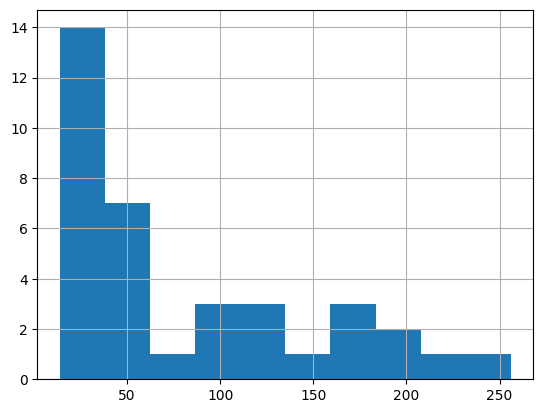

In [ ]:
#tokenização usando a biblioteca cl100k_base
# carrega o modelo cl100k_base
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('arqprocessado.csv', index_col=0)
df.columns = ['Textos']

# Tokeniza o texto e grava o nr de tokens
df['n_tokens'] = df.Textos.apply(lambda x: len(tokenizer.encode(str(x))))

# Visualiza a distribuição do numero de tokens por linha do Dataframe usando a histograma
df.n_tokens.hist()
#se for necessário usar a função abaixo para quebrar os textos

A API do ChatGPT pode limitar a quantidade de tokens, então essa função vai quebrar os tokens caso seja maior que 500.

In [ ]:
# usar aqui somente se o nr de tokens for maior que 500
max_tokens = 500

# Função para dividir o texto em partes de um número máximo de tokens
def split_into_many(text, max_tokens = max_tokens):

    # Dividir o texto em frases
    sentences = text.split(' ')

    # Obter o número de tokens para cada sentença
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]

    chunks = []
    tokens_so_far = 0
    chunk = []

    # Percorrer as sentenças e os tokens unidos em uma tupla
    for sentence, token in zip(sentences, n_tokens):

        # Se o número de tokens até o momento mais o número de tokens na frase atual for maior
        # do que o número máximo de tokens, adicione o bloco à lista de blocos e redefina
        # o bloco e os tokens até o momento
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # Se o número de tokens na frase atual for maior que o número máximo de
        # tokens, vá para a próxima sentença
        if token > max_tokens:
            continue

        # Caso contrário, adicione a frase ao bloco e adicione o número de tokens ao total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks


shortened = []

# Percorrer o dataframe
for row in df.iterrows():

    # Se o texto for None, vá para a próxima linha
    if row[1]['Textos'] is None:
        continue

    # Se o número de tokens for maior que o número máximo de tokens, divida o texto em partes
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['Textos'])

    # Caso contrário, adicione o texto à lista de textos abreviados
    else:
        shortened.append( row[1]['Textos'] )

Na sequencia analisamos a base para ver como ficou a tokenização

array([[<Axes: title={'center': 'n_tokens'}>]], dtype=object)

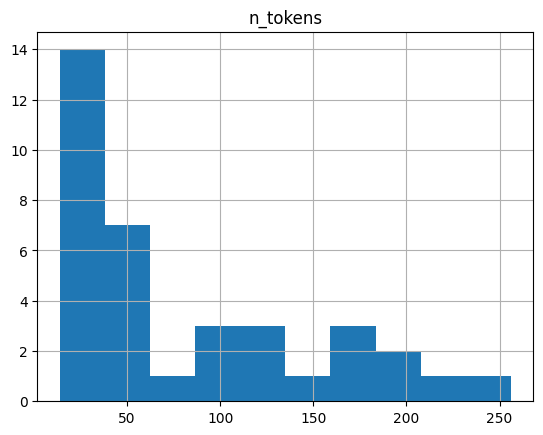

In [ ]:
# usar aqui somente se o nr de tokens for maior que 500
df = pd.DataFrame(shortened, columns = ['Textos'])
df['n_tokens'] = df.Textos.apply(lambda x: len(tokenizer.encode(str(x))))
df.hist(column='n_tokens')

Nos 2 trechos de códigos a seguir, faremos uma contagem dos tokens que temos no nosso arquivo de treino e quanto será cobrado em dólar. Incluímos esta análise, pois o ChatGPT (OpenIA) cobra pela quantidade de tokens trafegados/usados.


In [ ]:
num_tot_tokens = df['n_tokens'].sum()
print("Número total de tokens",num_tot_tokens)

Número total de tokens 2933


In [ ]:
i = 0
for text in df['Textos']:
    i+=1

print("Número de trechos de texto com no máximo",max_tokens,"tokens :",i)
print("Custo total de treinamento do embedding: $",num_tot_tokens /1000 * 0.0001)

Número de trechos de texto com no máximo 500 tokens : 36
Custo total de treinamento do embedding: $ 0.0002933


Aqui pegamos a chave da API_KEY que é gerada no site da OPENIA https://platform.openai.com/ para usar no CHAT

In [ ]:
#chave da API
def ler_openai_api_key():
    with open('openai_secret.txt', 'r') as file:
        api_key = file.read().strip()
    return api_key

openai.api_key = ler_openai_api_key()

Aqui transformamos os tokens no formato Embeding que é o formato que o ChatGPT usa para treinar.

In [ ]:
#fazer o embedding do texto
i = 0
embeddings = []
for text in df['Textos']:
    time.sleep(2)
    print(i)
    try:
        embedding = openai.Embedding.create(input=text, engine='text-embedding-ada-002')['data'][0]['embedding']
        print("Fazendo embedding do texto")
        embeddings.append(embedding)
    except openai.error.RateLimitError:
        print("Rate limit error, esperando 20 segundo antes de tentar novamente")
        time.sleep(20)
        embedding = openai.Embedding.create(input=text, engine='text-embedding-ada-002')['data'][0]['embedding']
        print("embedding texto depois de esperar 20 segundos")
        embeddings.append(embedding)
    i+=1

df['embeddings'] = embeddings
df.to_csv('embeddings.csv')
df.head()

0
Fazendo embedding do texto
1
Fazendo embedding do texto
2
Fazendo embedding do texto
3
Fazendo embedding do texto
4
Fazendo embedding do texto
5
Fazendo embedding do texto
6
Fazendo embedding do texto
7
Fazendo embedding do texto
8
Fazendo embedding do texto
9
Fazendo embedding do texto
10
Fazendo embedding do texto
11
Fazendo embedding do texto
12
Fazendo embedding do texto
13
Fazendo embedding do texto
14
Fazendo embedding do texto
15
Fazendo embedding do texto
16
Fazendo embedding do texto
17
Fazendo embedding do texto
18
Fazendo embedding do texto
19
Fazendo embedding do texto
20
Fazendo embedding do texto
21
Fazendo embedding do texto
22
Fazendo embedding do texto
23
Fazendo embedding do texto
24
Fazendo embedding do texto
25
Fazendo embedding do texto
26
Fazendo embedding do texto
27
Fazendo embedding do texto
28
Fazendo embedding do texto
29
Fazendo embedding do texto
30
Fazendo embedding do texto
31
Fazendo embedding do texto
32
Fazendo embedding do texto
33
Fazendo embedding

,Textos,n_tokens,embeddings
0,o grupo drummond é uma escola que possui curso...,24,"[-0.02404816821217537, 0.004340109881013632, -..."
1,para os cursos de graduação e pós graduação a ...,27,"[-0.013512169942259789, 0.004850185476243496, ..."
2,"o grupo drummond é referência em ensino, pesqu...",37,"[-0.03300058841705322, 0.007891444489359856, -..."
3,corpo acadêmico qualificado. contamos com prof...,36,"[-0.020967993885278702, 0.0033973539248108864,..."
4,"atualmente, o grupo é composto pelo centro uni...",121,"[-0.01036587730050087, 0.00922863744199276, -0..."


Aqui criamos o contexto para o assunto que vamos treinar o CHAT

In [ ]:
def create_context(question, df, max_len=1800, size="ada"):
    """
    Cria um contexto para uma pergunta encontrando o contexto mais similar no conjunto de embeddings gerado utilizando o Custom Knowledge.
    """

    # Obter a embeddings para a pergunta que foi feita
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Obter as distâncias a partir dos embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Classifique por distância e adicione o texto ao contexto
    for i, row in df.sort_values('distances', ascending=True).iterrows():

        # Adicionar o comprimento do texto ao comprimento atual
        cur_len += row['n_tokens'] + 4

        # Se o contexto for muito longo, quebre
        if cur_len > max_len:
            break

        # Caso contrário, adicione-o ao texto que está sendo retornado
        returns.append(row["Textos"])

    # Retornar o contexto
    return "\n\n###\n\n".join(returns)

Aqui vamos criar uma função para responder as perguntas específicas com base no Contexto criado acima

In [ ]:
def responder_perguntas(
                    df=df,
                    model="gpt-3.5-turbo-instruct",
                    question=None,
                    max_len=1800,
                    size="ada",
                    debug=False,
                    max_tokens=150,
                    stop_sequence=None):
  """
    Responder a uma pergunta com base no contexto mais semelhante dos textos do dataframe
  """

  context = create_context(
        question,
        df=df,
        max_len=max_len,
        size=size,
  )
  if debug:
      print("Context:\n" + context)
      print("\n\n")

  try:
      # Criar uma conclusão usando a pergunta e o contexto
      response = openai.Completion.create(
            prompt=f"Responda as perguntas com base no contexto abaixo, e se a pergunta não puder ser respondida diga \"Eu não sei responder isso\"\n\Contexto: {context}\n\n---\n\nPergunta: {question}\nResposta:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
      )
      return response['choices'][0]['text']
  except Exception as e:
        print(e)
    #     retornar ""

Aqui criamos um CHAT para demonstrar o Treinamento. Conforme instrução/texto colocada no Contexto acima. Se a pergunta estiver fora do contexto, o chat responderá que Não sabe responder.

In [ ]:
print("Entre com sua DÚVIDA ou escreva SAIR para finalizar: ")
while True:
  mensagem = input('')
  if mensagem.upper() == "SAIR":
    break
  else:
    resposta = responder_perguntas(question=mensagem,debug=False)
    print("RESPOSTA: ",resposta,'\n')

print("Até mais....")